# Heteroscedastic loss tutorial

In this tutorial, we show how to quickly set up and train an RNN regression model with the deep4cast package. The goal is to show you how to handle the package interface and inspect the model object after training. The example data constitutes of a monthly 26-dimensional multivariate time series.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
import deep4cast.metrics as metrics
from pandas import read_table

%matplotlib inline

Using TensorFlow backend.


## Data preparation

Before we can fit a model we first have to load, clean, and prepare our dataset so that the model can accept it.

Text(0,0.5,'Quantity')

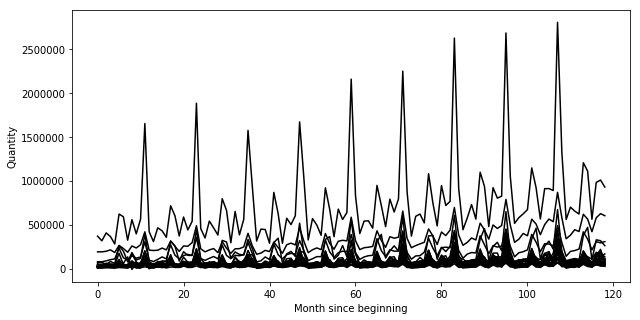

In [2]:
# Load the data from file
filename = 'timeseries_data.csv'
df = read_table(filename, sep=',')

# Prepare the data set
data = df.values
data = np.expand_dims(data, 0)
holdout = 9
train_data = data[:,:-9,:]
test_data = data[:,-9:,:]

# Plot the dataset
plt.figure(figsize=(10,5))
plt.plot(data[0], 'k')
plt.xlabel('Month since beginning')
plt.ylabel('Quantity')

## Recurrent Neural Network Forecaster using LSTM cells

Now that we have cleaned and prepared our dataset, we can proceed to fit a regression model. Here, we choose the LSTM-RNN, with windowed training intput.

In [3]:
topology = [
    {
        'meta': {
            'layer_type': 'LSTM', 
            'layer_id': 'lstm1', 
            'parent_ids': ['input']
        },
        'params': {
            'units': 32, 
            'return_sequences': True
        }
    },
    {
        'meta': {
            'layer_type': 'LSTM', 
            'layer_id': 'lstm1', 
            'parent_ids': ['input']
        },
        'params': {
            'units': 32, 
            'return_sequences': False
        }
    }
]

Now, we can set up the forecaster object using arguments to specify lookbacks and forecasting horizons, as well as optimizer parameters

In [59]:
forecaster = Forecaster(
    topology,
    optimizer='rmsprop',
    loss='mse',
    lookback=20,
    horizon=9,
    lr=0.001
)
forecaster.seed = 3 # Let's fix the seed

We can now fit the forecaster and unspect the training and validation losses

In [60]:
forecaster.fit(train_data, patience=100)

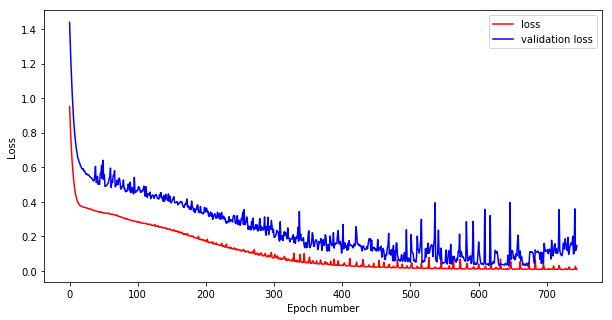

In [61]:
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r')
plt.plot(forecaster.history.epoch, forecaster.history.history['val_loss'], 'blue') 
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(['loss', 'validation loss'])

Using the trained model, we can make predictions for our dataset. The horizon parameter of the forecaster will determine how far into the future our predictions will reach.

In [62]:
predictions = forecaster.predict(train_data, n_samples=1)

Let's get the test set accuracy from model

In [63]:
predictions['std']

In [66]:
metrics.mape(test_data, predictions['mean'])

21.84962876607988

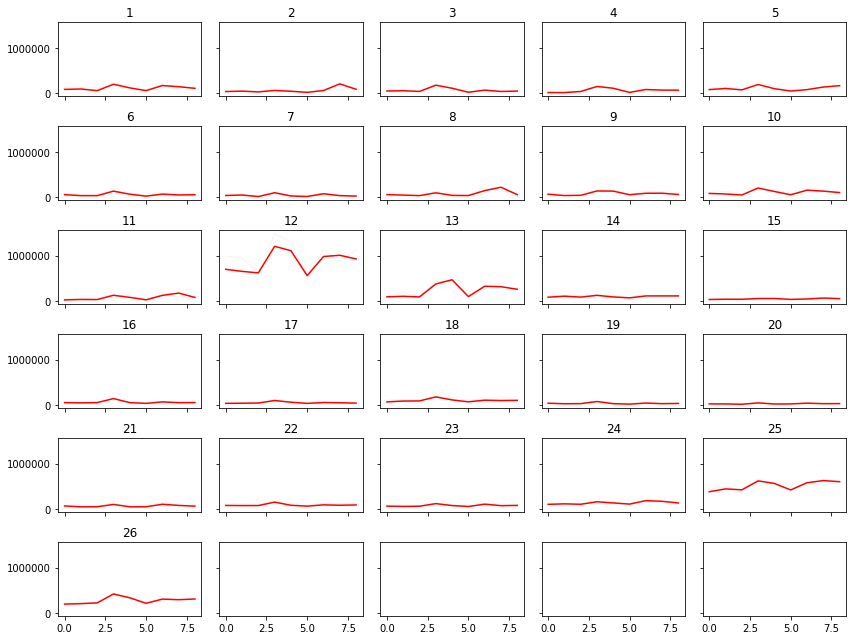

In [67]:
ncols = 5
fig, axes = plt.subplots(nrows=26//ncols+1, ncols=ncols, sharex=True, sharey=True, figsize=(12, 9))
for ax, ya, yp, title in zip(axes.flat, 
                             test_data[0,:,:].T,
                             predictions['samples'].T,
                             range(1,26+1)):
    for ys in yp.T:
        ax.plot(ys[0,:], 'g-', alpha=0.05)
    ax.plot(ya, 'r-')
    ax.set_title(title)

plt.tight_layout()